In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# run these every time there are updates to resolution, binning, or mephistograms
# load and prepare the energy and angular resolutions
%run ../../core/resolution.py
# gather all ingredients and save them as unified 'mephistogram' data structure
%run ../../core/prepare_histograms.py

file exists: /home/lisajsch/repos/Plenum/local/e_psf_grid_psimax-3_bins-25.pckl
running gaussian-process resolution smoothing
file exists: /home/lisajsch/repos/Plenum/local/GP_Eres_mephistograms.pckl
140 log_10(energy) bins
100 declination bins
140 log_10(energy) bins
100 declination bins
Elementary arithmetic possible.
True


In [4]:
import numpy as np
from glob import glob
from tools import ang_dist
from settings import *

import pickle
from collections import namedtuple
from itertools import product
from copy import copy
from os.path import join

import pandas as pd
import seaborn as sns
from aeff_calculations import calc_aeff_factor
from fluxes import (
    astro_flux,
    atmo_background,
    cut_off,
    power_law,
)
import mephisto
from matplotlib.colors import LogNorm
from scipy.optimize import fmin_l_bfgs_b
from scipy.stats import chi2, norm
from tools import array_source_interp, poisson_llh
from tqdm import tqdm


# Real data

In [5]:
# 10yr data release
exp_data = []
for fn in glob("/data/plenum/icecube_10year_ps/events/*.csv"):
    exp_data.extend(np.genfromtxt(fn, names=True))
exp_data = np.array(exp_data)


In [6]:
angular_distances = np.rad2deg(
    ang_dist(
        ngc1068.ra.rad,
        ngc1068.dec.rad,
        np.deg2rad(exp_data["RAdeg"]),
        np.deg2rad(exp_data["Decdeg"]),
    )
)[0]


# select events within the analysis window
ngc_dist_mask = angular_distances <= delta_psi_max
ngc_events = exp_data[ngc_dist_mask]
ngc_angular_distances = angular_distances[ngc_dist_mask]

# select events in declination band
dec_distances = np.rad2deg(
    ang_dist(
        0,
        ngc1068.dec.rad,
        np.zeros_like(exp_data["RAdeg"]),
        np.deg2rad(exp_data["Decdeg"]),
    )
)[0]

ngc_dec_mask = ~ngc_dist_mask & (dec_distances <= delta_psi_max)
ngc_dec_events = exp_data[ngc_dec_mask]
ngc_dec_distances = dec_distances[ngc_dec_mask]

In [7]:
# ngc1068 data release
# new_ev = pd.read_csv("/home/lisajsch/Downloads/20220913_Evidence_for_neutrino_emission_from_the_nearby_active_galaxy_NGC_1068_data/ps_data_release/resources/event_list.txt")

Text(0, 0.5, 'dec/deg')

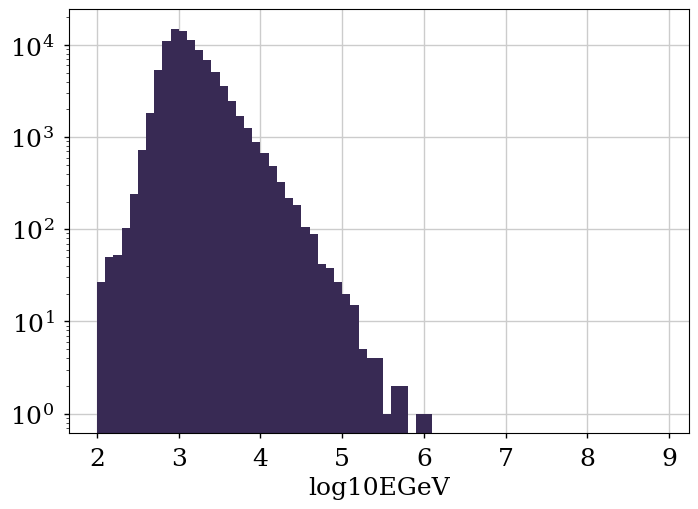

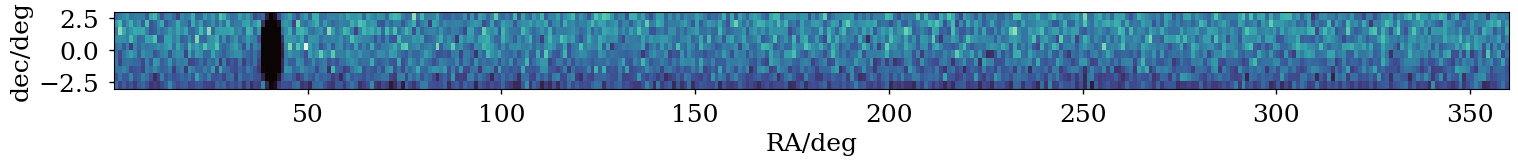

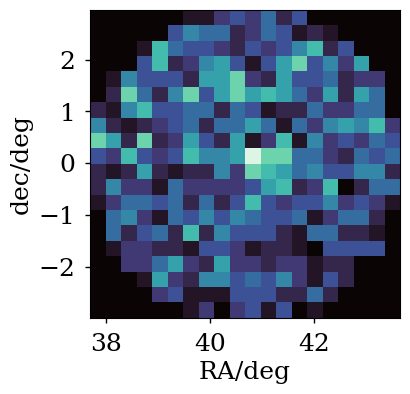

In [8]:
plt.figure()
plt.hist(ngc_dec_events["log10EGeV"], bins=logE_reco_bins[::2])
plt.yscale("log")
plt.xlabel("log10EGeV")

plt.figure(figsize=(18, 1))
_ = plt.hist2d(ngc_dec_events["RAdeg"], ngc_dec_events["Decdeg"], bins=(360, 10))
plt.xlabel("RA/deg")
plt.ylabel("dec/deg")

plt.figure(figsize=(4, 4))
_ = plt.hist2d(ngc_events["RAdeg"], ngc_events["Decdeg"], bins=20)
plt.xlabel("RA/deg")
plt.ylabel("dec/deg")

# Effective area

We use here only upgoing events with dec>-5deg, since this is the threshold for a pure data set with few muons.

In [9]:
with open(join(LOCALPATH, "effective_area_MH_upgoing.pckl"), "rb") as f:
    aeff_2d = pickle.load(f)

# Atmospheric background

In [10]:
with open(join(LOCALPATH, "atmospheric_background_MH.pckl"), "rb") as f:
    bckg_histo = pickle.load(f)

# check if histos are matching
print(bckg_histo.match(aeff_2d["IceCube"], verbose=True))


Elementary arithmetic possible.
True


# Energy resolution function

Plotting code can be found in `energy_resolution.ipynb`

In [11]:
with open(join(LOCALPATH, "GP_Eres_mephistograms.pckl"), "rb") as f: #
    all_eres = pickle.load(f)
# select only horizontal resolution
baseline_eres = all_eres['dec-0.0']
baseline_eres.normalize(axis=1) # normalize per logE_true


# Psi²-Energy resolution

NOTE: psi changes per detector over the day. For the sake of (optimistic) simplicity, we choose the horizontal resolution for all detectors

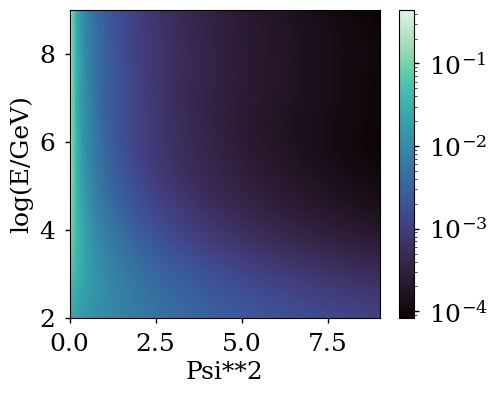

In [12]:
# angular resolution
with open(join(LOCALPATH, "Psi2_res_mephistograms.pckl"), "rb") as f:
    all_psi = pickle.load(f)
# select only horizontal resolution
e_psi2_grid = all_psi["dec-0.0"]
e_psi2_grid.normalize()

# uniform, normalized background grid
bckg_psi2_grid = mephisto.like(e_psi2_grid, fill_value=1)
bckg_psi2_grid.normalize()

e_psi2_grid.plot(norm=LogNorm())

# Flux definition

In [13]:
# we base the flux models on named-tuples
PL_flux = namedtuple("PL_flux", "norm gamma E0 shape")
PLcut_flux = namedtuple("PLcut_flux", "norm gamma e_cut E0 shape")
LogP_flux = namedtuple("LogP_flux", "norm alpha beta E0 shape")

flux_collection = {
    "powerlaw": PL_flux,
    "powerlaw with cutoff": PLcut_flux,
    "log-parabola": LogP_flux,
}

## NGC1068 source parameters

In [14]:
# ngc flux error contour
gamma_c_68, phi_c_68 = np.loadtxt(join(LOCALPATH, "ngc_paper_68_contour.txt"))
phi_c_68 /= 1E11

# 10yr PS paper (data release)
gamma_c_68_prev, phi_c_68_prev = np.loadtxt(join(LOCALPATH, "tenyr_paper_68_contour.txt"))
phi_c_68_prev *= 1E-3

ngc_flux = PL_flux(PHI_NGC, GAMMA_NGC, E0_NGC, "powerlaw")


In [15]:
# generic source config without dec coordinate
src_config = dict(
    sindec_mids=sindec_mids,
    livetime=LIVETIME,
    ewidth=ewidth,
    dpsi_max=0,
    grid_2d=e_psi2_grid,
)
# generic bg config
bg_config = copy(src_config)
bg_config["dpsi_max"] = delta_psi_max
bg_config["grid_2d"] = bckg_psi2_grid

# ... with ngc declination
ngc_src_config = copy(src_config)
ngc_src_config["dec"] = ngc1068.dec.rad
ngc_bg_config = copy(bg_config)
ngc_bg_config["dec"] = ngc1068.dec.rad


# Set up LLH function
$ \mathcal{L}({\rm data}~k~ |~{\rm hypothesis}~\mu)
    = \prod_{{\rm bin\,}ij}^{N_{\rm bins}} \frac{\mu_{ij}^{k_{ij}}}{k_{ij}!}\cdot
    \exp \left( -\mu_{ij} \right)$


Background hypothesis $H_0(\mu = N_B)$ : only atmospheric neutrino flux

Signal hypothesis $H_1(\mu = \{N_B, N_S, \gamma\})$: atmospheric neutrino flux + astrophysical neutrino flux

Idea: data ($k$) are the perfect representation of our expectation; the hypothesis ($\mu$) is the model with the free parameters we'd like to know



In [16]:
def ps_llh_2d_composite(
    x,
    mu_b_base,
    mu_s_base,
    k_i,
    e_0,
    phi_0,
    shape,
    energy_resolution,
    verbose=False,
):
    """fit parameters in x:
    x[0]: background normalization scaling
    x[1]: signal normalization scaling
    x[2:]: other signal parameters
        see 'astro_flux' for further shapes and parameters

    mu_b_base: background baseline
    mu_s_base: effective area factor for signal
    k_i: observation/asimov data
    e_0: normalization energy, default E0_NGC
    phi_0: normalization flux, default PHI_NGC
    shape: flux shape
    """
    mu_b = mu_b_base * x[0]
    mu_s = astro_flux(
        mu_s_base,
        emids,
        energy_resolution,
        x[1],
        flux_collection[shape](
            phi_0, *x[2:], e_0, shape
        ),  # here we generate a flux tuple with the current parameters
    )
    if verbose:
        print(x[0], x[1], *x[2:])
        print(flux_collection[shape](phi_0, *x[2:], e_0, shape))
        print(np.sum(mu_b), np.sum(mu_s))
    mu_i = mu_s + mu_b

    return poisson_llh(mu_i, k_i)



# Asimov data

In [18]:
idents = ["IceCube", "Plenum-1", "Plenum-2"]
for ident in idents:
    print(ident)
    print("=" * 10)

    aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], **ngc_bg_config)
    aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)
    if "Plenum" in ident or "P-ONE" in ident:
        aeff_factor_bckg += calc_aeff_factor(aeff_2d["IceCube"], **ngc_bg_config)
        aeff_factor_signal += calc_aeff_factor(aeff_2d["IceCube"], **ngc_src_config)
    # asimov data
    k_b = atmo_background(
        aeff_factor=aeff_factor_bckg,
        bckg_vals=array_source_interp(ngc_src_config["dec"], bckg_histo, sindec_mids, axis=1),
        energy_resolution=baseline_eres,
    )
    # background estimation from data
    bg_data = mephisto.like(k_b, fill_value=0)

    # power law
    k_s = astro_flux(
        aeff_factor=aeff_factor_signal,
        emids=emids,
        energy_resolution=baseline_eres,
        phi_scaling=1,
        flux_shape=ngc_flux,  # powerlaw
    )
    k_i = k_s + k_b

    print("Asimov data sum:")
    print("Background:", np.sum(k_b))
    print("Signal:", np.sum(k_s))


    dct = dict(
        shape="powerlaw",
        mu_b_base=k_b,
        mu_s_base=aeff_factor_signal,
        k_i=k_i,
        e_0=ngc_flux.E0,
        phi_0=ngc_flux.norm,
        energy_resolution=baseline_eres,
    )

    # fix signal normalization to 0
    local_llh = lambda x: ps_llh_2d_composite((x[0], 0, 3), **dct)
    global_llh = lambda x: ps_llh_2d_composite(x, **dct)

    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1,),
        approx_grad=True,
    )
    print("Atmo-only normalization:", out_bckg[0])

    # this fit is not really needed, but good for crosschecking the code
    out_comp = fmin_l_bfgs_b(
        global_llh,
        x0=(1, 1, ngc_flux.gamma),
        approx_grad=True,
    )
    print("Signal fit parameters:", out_comp[0])
    print("TS check:", global_llh((1, 1, ngc_flux.gamma)), "(fit: ", out_comp[1], ")")
    print("-2 Delta LLH:", out_bckg[1] - out_comp[1])

    pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
    significance = norm.isf(pval)
    print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
    print()

IceCube
Asimov data sum:
Background: 1171.0718512641517
Signal: 85.16201580234387
Atmo-only normalization: [1.07271235]
Signal fit parameters: [1.  1.  3.2]
TS check: -303812.2293762008 (fit:  -303812.2293762008 )
-2 Delta LLH: 20.819867504760623
P-VALUE: 3.0131670828395342e-05 SIGNIFICANCE: 4.011777276976178

Plenum-1
Asimov data sum:
Background: 4965.415505178296
Signal: 363.86356026446543
Atmo-only normalization: [1.07327961]
Signal fit parameters: [1.  1.  3.2]
TS check: -271770.8020530288 (fit:  -271770.8020530288 )
-2 Delta LLH: 83.42063007882098
P-VALUE: 7.6813992722891e-19 SIGNIFICANCE: 8.78698448743479

Plenum-2
Asimov data sum:
Background: 12557.74629682905
Signal: 916.0388785593486
Atmo-only normalization: [1.07294628]
Signal fit parameters: [1.  1.  3.2]
TS check: -238699.54010621645 (fit:  -238699.54010621645 )
-2 Delta LLH: 218.33440494019305
P-VALUE: 3.884063865869572e-48 SIGNIFICANCE: 14.530473794893535



# real data
## plotting

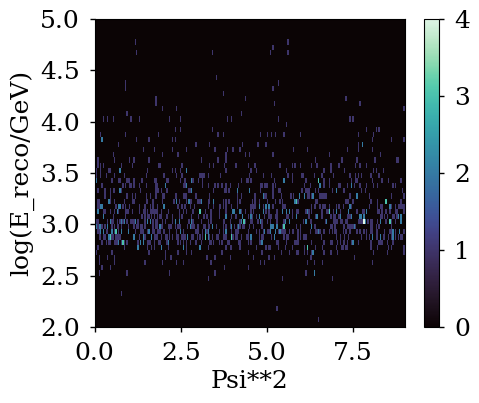

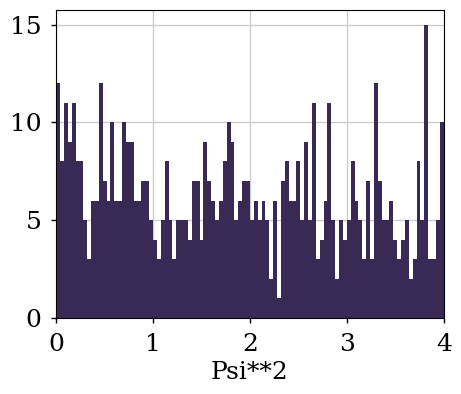

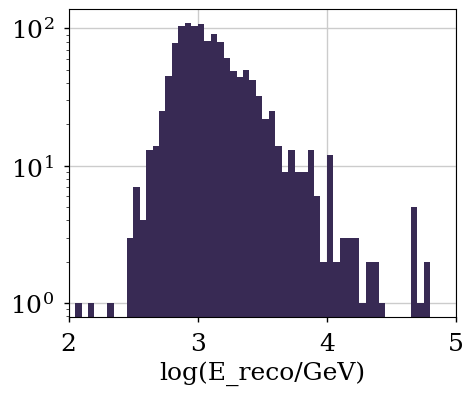

In [19]:
data_hist = mephisto.Mephistogram(
    (ngc_angular_distances**2, ngc_events["log10EGeV"]),
    bins=k_s.bins,
    axis_names=k_s.axis_names,
    make_hist=True
)

data_hist.plot()
plt.ylim(2, 5)

data_hist.sum(axis=1, return_mephisto=True).plot()
plt.gca().set_xlim(0, 4)
data_hist.sum(axis=0, return_mephisto=True).plot()

plt.xlim(2, 5)
plt.gca().set_yscale("log")


(2.0, 5.0)

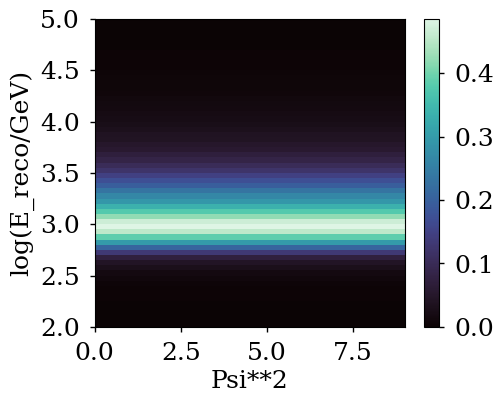

In [20]:
# make the background PDF from data
# use the energy distribution for one axis...
data_bg_hist, _ = np.histogram(ngc_dec_events["log10EGeV"], bins=logE_reco_bins)

# ... and a uniform distribution for the angular distance axis
data_bg = mephisto.Mephistogram(
    np.tile(data_bg_hist, len(psi2_mids)).reshape(data_hist.shape),
    bins=data_hist.bins,
    axis_names=data_hist.axis_names,
    make_hist=False,
)
# normalize such that it matches the data
# then the BG normalization will be close to 1 in the fit
data_bg.normalize(mode="full")
data_bg *= data_hist.sum()
data_bg.plot()
plt.ylim(2, 5)


## analysis

Atmo-only normalization: [1.00000005]
Signal fit parameters: [0.94000161 0.85788316 3.03450143]
P-VALUE: 3.599126095623381e-05 SIGNIFICANCE: 3.969635967102826


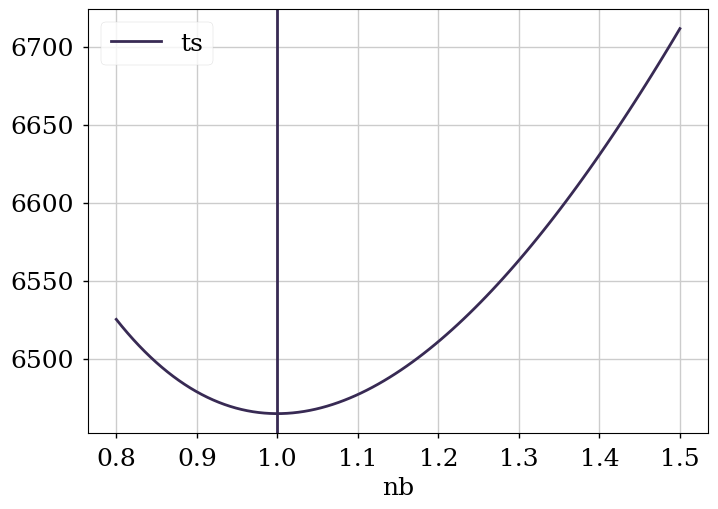

In [24]:
ident = "IceCube"
aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], **ngc_bg_config)
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)
# asimov data with baseline fluxes

### we use the bg from data instead! ###

# k_b = atmo_background(
#    aeff_factor=aeff_factor_bckg,
#    bckg_vals=array_source_interp(
#        ngc_src_config["dec"], bckg_histo, sindec_mids, axis=1
#    ),
#    energy_resolution=baseline_eres,
# )

dct = dict(
    shape="powerlaw",
    mu_b_base=data_bg,  # we use the bg from data instead!
    mu_s_base=aeff_factor_signal,
    k_i=data_hist,
    e_0=ngc_flux.E0,
    phi_0=ngc_flux.norm,
    energy_resolution=baseline_eres,
)

bg_llh = lambda x: ps_llh_2d_composite((x[0], 0, 3), **dct)

out_bckg = fmin_l_bfgs_b(
    bg_llh,
    x0=(1.1,),
    approx_grad=True,
)
print("Atmo-only normalization:", out_bckg[0])

# make parameter scans as crosscheck
# background-only scan
bg_ts = []
for nb in np.linspace(0.8, 1.5, 100):
    bg_ts.append({"ts": ps_llh_2d_composite((nb, 0, 3), **dct), "nb": nb})

bg_ts = pd.DataFrame(bg_ts)
bg_ts.plot(x="nb", y="ts")
plt.axvline(out_bckg[0])

# full optimization of all parameters

global_llh = lambda x: ps_llh_2d_composite(x, **dct)

# S+B fit
out_global = fmin_l_bfgs_b(
    global_llh,
    x0=(1, 1, ngc_flux.gamma),
    bounds=[(1e-3, 10), (1e-3, 10), (1e-3, 10)],
    approx_grad=True,
)
print("Signal fit parameters:", out_global[0])

# significance
pval = chi2.sf(out_bckg[1] - out_global[1], 2)
significance = norm.isf(pval)
print("P-VALUE:", pval, "SIGNIFICANCE:", significance)


## data PDF agreement

(0.1, 300.0)

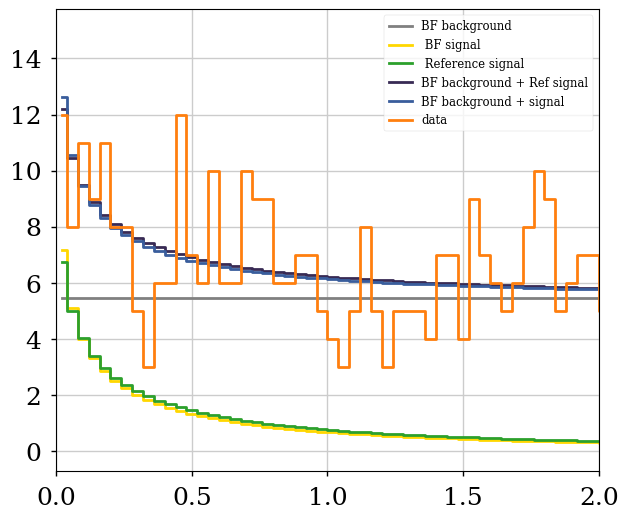

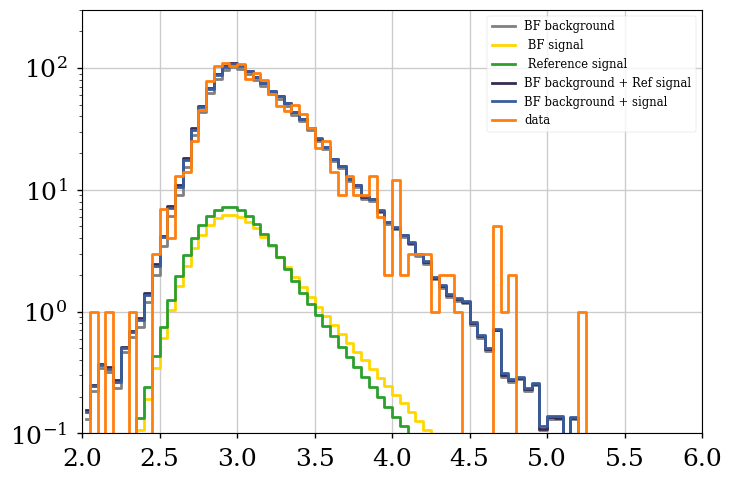

In [25]:
# compare psi and energy histograms of data and best-fit
ident = "IceCube"
aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], **ngc_bg_config)
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)

# asimov data with baseline fluxes
k_b = data_bg * out_global[0][0]
# atmo_background(
#     aeff_factor=aeff_factor_bckg * out_global[0][0],
#     bckg_vals=array_source_interp(
#         ngc_src_config["dec"], bckg_histo, sindec_mids, axis=1
#     ),
#     energy_resolution=baseline_eres,
# )

bf_ngc_flux = PL_flux(PHI_NGC * out_global[0][1], out_global[0][2], E0_NGC, "powerlaw")
k_s = astro_flux(
    aeff_factor=aeff_factor_signal,
    emids=emids,
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=bf_ngc_flux,  # powerlaw
)

k_s_ref = astro_flux(
    aeff_factor=aeff_factor_signal,
    emids=emids,
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=ngc_flux,  # powerlaw
)


k_sum_ref = k_s_ref + k_b
k_sum_bf = k_s + k_b

# plot data and baseline flux comparison
plt.figure(figsize=(7, 6))
plt.plot(
    k_b.bin_mids[0],
    k_b.sum(axis=1),
    ds="steps-mid",
    label="BF background",
    color="gray",
)

p = plt.plot(
    k_s.bin_mids[0], k_s.sum(axis=1), ds="steps-mid", label=" BF signal", color="gold"
)
p = plt.plot(
    k_s_ref.bin_mids[0], k_s_ref.sum(axis=1), ds="steps-mid", label=" Reference signal", color="tab:green"
)
p = plt.plot(
    k_sum_ref.bin_mids[0],
    k_sum_ref.sum(axis=1),
    ds="steps-mid",
    label="BF background + Ref signal",
)
p = plt.plot(
    k_sum_bf.bin_mids[0],
    k_sum_bf.sum(axis=1),
    ds="steps-mid",
    label="BF background + signal",
)
plt.plot(
    data_hist.bin_mids[0],
    data_hist.sum(axis=1),
    ds="steps-mid",
    label="data",
    color="tab:orange",
)
plt.xlim(0, 2)
plt.legend(loc=0, fontsize="small")

# plot data and baseline flux comparison
plt.figure()
plt.plot(
    k_b.bin_mids[1],
    k_b.sum(axis=0),
    ds="steps-mid",
    label="BF background",
    color="gray",
)

p = plt.plot(
    k_s.bin_mids[1], k_s.sum(axis=0), ds="steps-mid", label=" BF signal", color="gold"
)
p = plt.plot(
    k_s_ref.bin_mids[1], k_s_ref.sum(axis=0), ds="steps-mid", label=" Reference signal", color="tab:green"
)
p = plt.plot(
    k_sum_ref.bin_mids[1],
    k_sum_ref.sum(axis=0),
    ds="steps-mid",
    label="BF background + Ref signal",
)
p = plt.plot(
    k_sum_bf.bin_mids[1],
    k_sum_bf.sum(axis=0),
    ds="steps-mid",
    label="BF background + signal",
)
plt.plot(
    data_hist.bin_mids[1],
    data_hist.sum(axis=0),
    ds="steps-mid",
    label="data",
    color="tab:orange",
)
plt.xlim(2, 6)
plt.legend(loc=0, fontsize="small")
plt.yscale("log")
plt.ylim(1e-1, 3e2)


## profile likelihood 
Contour -> optimize nb on a gamma-ns grid
Also, cross-check the BF results for the Global LLH


In [26]:
sig_ts = []
num = 30
g_space = np.linspace(2.3, 4.1, num=num+1)
ns_space = np.logspace(-0.8, 0.3, num=num)

for g, s in product(g_space, ns_space):
    tmp = {}
    tmp["ns"] = s
    tmp["gamma"] = g

    _llh = lambda x: ps_llh_2d_composite((x[0], s, g), **dct)

    # S+B fit
    out_profile = fmin_l_bfgs_b(
        _llh,
        x0=(1, ),
        bounds=[(1E-3, 10),],
        approx_grad=True,
    )

    tmp["ts"] = out_profile[1]
    tmp["delta_ts"] = out_profile[1] - out_global[1]
    tmp["nb"] = out_profile[0][0]
    sig_ts.append(tmp)

sig_ts = pd.DataFrame(sig_ts)

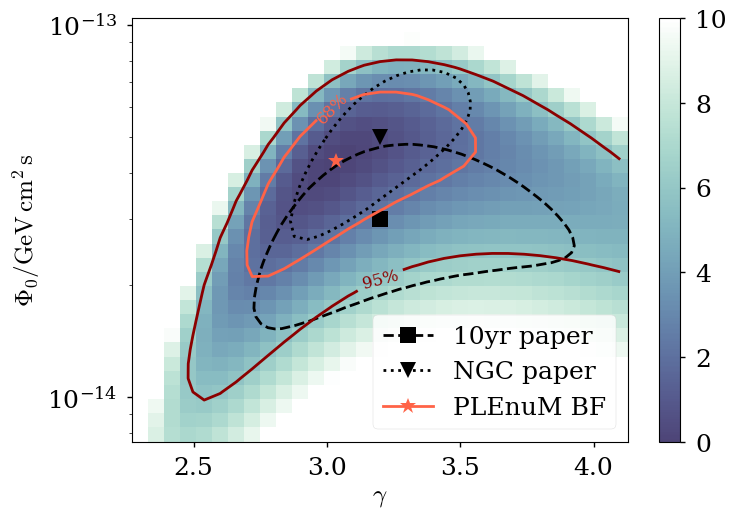

In [27]:
sig_ts["norm"] = sig_ts["ns"] * ngc_flux.norm
sig_ts_piv = sig_ts.pivot(index="norm", columns="gamma", values="delta_ts")
cvals = [0.32, 0.05]
lbs = ["68%", "95%"]
levels = chi2.isf(cvals, 2)
cur_cmap = sns.cubehelix_palette(
    start=0.5, rot=-0.5, light=1, dark=0.3, as_cmap=True, reverse=True
)
plt.pcolormesh(
    sig_ts_piv.columns, sig_ts_piv.index, sig_ts_piv, vmin=0, vmax=10, cmap=cur_cmap
)
plt.colorbar()

plt.plot(gamma_c_68_prev, phi_c_68_prev, color="k", ls="--")
plt.plot(3.2, 3e-14, color="k", marker="s", label="10yr paper", ms=12, ls="--")

plt.plot(gamma_c_68, phi_c_68 * 1E-3, color="k", ls=":")
plt.plot(3.2, 5e-14, color="k", marker="v", label="NGC paper", ms=12, ls=":")


plt.plot(
    out_global[0][2],
    out_global[0][1] * ngc_flux.norm,
    color="tomato",
    marker="*",
    ms=12,
    label="PLEnuM BF",
)
sc = plt.contour(
    sig_ts_piv.columns,
    sig_ts_piv.index,
    sig_ts_piv,
    levels=levels,
    lw=3,
    colors=["tomato", "darkred"],
)

fmt = {l: s for l, s in zip(sc.levels, lbs)}
plt.clabel(sc, levels, fmt=fmt, fontsize=12)



plt.xlabel(r"$\gamma$")
plt.ylabel(r"$\Phi_0 / {\rm GeV\, cm^2\, s}$")
plt.yscale("log")
plt.legend(loc=4)


# cutoff fit

In [25]:
ident = "IceCube"
aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], **ngc_bg_config)
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)
# asimov data with baseline fluxes

### we use the bg from data instead! ###

dct = dict(
    mu_b_base=data_bg,  # we use the bg from data instead!
    mu_s_base=aeff_factor_signal,
    k_i=data_hist,
    e_0=E0_NGC,
    phi_0=7E-14, # rough estimate
    energy_resolution=baseline_eres,
)

pl_func = lambda x: ps_llh_2d_composite(x, shape="powerlaw", **dct)
out_bckg = fmin_l_bfgs_b(
    pl_func,
    x0=(1.2, 1.2, 3.0),
    approx_grad=True,
)
print("bckg params:", out_bckg[0])

# full optimization of all parameters
comp = lambda x: ps_llh_2d_composite(x, shape="powerlaw with cutoff", **dct)
out_comp = fmin_l_bfgs_b(
    comp,
    x0=(1.2, 1.1, 1.9, 3.4),
    approx_grad=True,
)
print("Signal fit parameters:", out_comp[0])

# significance
# 1 ndof.
pval = chi2.sf(out_bckg[1] - out_comp[1], 1)
significance = norm.isf(pval)
print("P-VALUE:", pval, "SIGNIFICANCE:", significance)

# scan 
## TODO


bckg params: [0.94000261 0.61273631 3.03447528]
Signal fit parameters: [0.94000017 0.61278534 3.03451302 9.56650579]
P-VALUE: 1.0 SIGNIFICANCE: -inf
